# Linear regression method
This notebook contains a linear regression method for creating a prediction model. It contains lasso and ridge regressions iterated on ECFP, CDDD and a mix of CDDD and ECFP data separately to find the best regression on the best dataset.

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from copy import deepcopy


In [24]:
datas_folder = "clean_datas/"
train_data_file = "ecfp_train.csv"
test_data_file = "ecfp_test.csv"
cddd_train_file = "cddd_train.csv"
cddd_test_file =  "cddd_test.csv"
mix_train_file = "mix_test.csv"
mix_test_file = "mix_train.csv"

train = pd.read_csv(datas_folder + train_data_file)
test = pd.read_csv(datas_folder + test_data_file)
cddd_train = pd.read_csv(datas_folder + cddd_train_file)
cddd_test = pd.read_csv(datas_folder + cddd_test_file)
mix_train = pd.read_csv(datas_folder + mix_train_file)
mix_test = pd.read_csv(datas_folder + mix_test_file)

# Creating an empty DataFrame with two columns "Value" and "Label" to visually check results
#score = pd.DataFrame(columns=['mean score', 'value'])

## Loss calculation and data preparation functions
The custom_loss function defines a customized loss metric based on the root mean square error after exponential transformation of the values. The prep_fitt function prepares the data by removing certain columns for model training.

In [4]:
def custom_loss(y_true, y_pred):
    y_pred_exp = np.exp(y_pred)
    loss = mean_squared_error(np.exp(y_true), y_pred_exp) 
    return loss
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

def prep_fitt(datas):
    datas = datas.copy()
    try:
        return datas.drop(labels=["RT", "SMILES", "mol", "Compound"], axis=1)
    except Exception:
        return datas.drop(labels=["SMILES", "mol", "Compound"], axis=1)



## ECFP LINEAR REGRESSION
Use of linear regression on ECFP dataset. The first part uses ridge linear regression and the second uses Lasso. The aim is to compare their effectiveness.

Preparing data for use:

In [5]:
train_log = np.log(train["RT"])
true_y = train["RT"]
X = prep_fitt(train)
y = train_log
X_test = prep_fitt(test)

### RIDGE
The Ridge regression (on ECFP) implementation with a nested cross-validation:

In [ ]:
#ECFP : one hot-encoded drop but not first  / linear regression / ridge / nested cross validation / 
pipeline = Pipeline([ 
    ("model", Ridge())
    ])
param_grid = [{'model__alpha': np.logspace(-3, 3,100 )}]

# Setup inner and outer cross-validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV for hyperparameter tuning
model = GridSearchCV(
	estimator=pipeline, param_grid=param_grid, cv=inner_cv, 
                           scoring=custom_scorer)

# Fit model using GridSearchCV on the training data
model.fit(X,y)
print("Best alpha parameters:", model.best_params_)

# Perform nested cross-validation for model evaluation
nested_score=cross_val_score(model, X, y, cv=outer_cv, 
                           scoring=custom_scorer) 

# Display cross-validated scores, mean score, and standard deviation of RMSE
print("Cross-validated scores:", nested_score)
print("Mean score:", np.mean(nested_score))
print("Standard Deviation of RMSE: ", nested_score.std())

# Make predictions on training and test data
y_pred_test_log = model.predict(X_test)
y_pred_train_log = model.predict(X)
y_pred_test = np.exp(y_pred_test_log)
y_pred_train = np.exp(y_pred_train_log)

# Create a DataFrame with test predictions and save to a CSV file
sub_dataframe = pd.DataFrame(list(enumerate(y_pred_test, start=1)), columns=['ID', 'RT'])
submission = 'prediction/ecfp_ridge.csv'     
sub_dataframe.to_csv(submission, index=False)

# Calculate and display the training error (Root Mean Squared Error)
print("Training error is: {} ".format(np.sqrt(mean_squared_error(y_pred_train, true_y))))

# Adding values and labels to the DataFrame to visually check results
#score = score.append({'mean score': np.mean(nested_score), 'Method': 'Ridge regression on ECFP'}, ignore_index=True)


### LASSO
The Lasso regression implementation (on ECFP) with a nested cross-validation:

In [ ]:
#ECFP : one hot-encoded drop but not first / linear regression / lasso / nested cross validation / 

# Creating a Lasso regression pipeline
lasso_pipeline = Pipeline([ 
    ("model", Lasso())
])

# Defining grid of hyperparameters for Lasso regression alpha parameter
lasso_param_grid = [{'model__alpha': np.logspace(-3, 3, 100)}]

# Setting up inner and outer cross-validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing GridSearchCV for hyperparameter tuning with Lasso regression
lasso_model = GridSearchCV(
    estimator=lasso_pipeline, param_grid=lasso_param_grid, cv=inner_cv, 
    scoring=custom_scorer
)

# Fitting the Lasso model using GridSearchCV on the entire dataset
lasso_model.fit(X, y)

print("Best alpha parameters (Lasso):", lasso_model.best_params_)


# Performing nested cross-validation for evaluating the Lasso model's performance
lasso_nested_score = cross_val_score(lasso_model, X, y, cv=outer_cv, scoring=custom_scorer)

# Displaying cross-validated scores, mean score, and standard deviation of RMSE for Lasso
print("Cross-validated scores (Lasso):", lasso_nested_score)
print("Mean score (Lasso):", np.mean(lasso_nested_score))
print("Standard Deviation of RMSE (Lasso):", lasso_nested_score.std())

# Making predictions on training and test datasets using the Lasso model
y_pred_test_log_lasso = lasso_model.predict(X_test)
y_pred_train_log_lasso = lasso_model.predict(X)
y_pred_test_lasso = np.exp(y_pred_test_log_lasso)
y_pred_train_lasso = np.exp(y_pred_train_log_lasso)

# Creating a DataFrame with test predictions from Lasso model and saving to a CSV file
sub_dataframe_lasso = pd.DataFrame(list(enumerate(y_pred_test_lasso, start=1)), columns=['ID', 'RT'])
submission_lasso = 'prediction/ecfp_lasso.csv'     
sub_dataframe_lasso.to_csv(submission_lasso, index=False)

# Calculating and displaying the training error (RMSE) for the Lasso model
print("Training error (Lasso) is: {} ".format(np.sqrt(mean_squared_error(y_pred_train_lasso, true_y))))

# Adding values and labels to the DataFrame to visually check results
#score = score.append({'mean score': np.mean(nested_score), 'Method': 'Lasso regression on ECFP'}, ignore_index=True)

## CDDD LINEAR REGRESSION
Use of linear regression on CDDD dataset. The first part uses ridge linear regression and the second uses Lasso. The aim is to compare their effectiveness.

Preparing data for use:

In [8]:
cddd_train_log = np.log(cddd_train["RT"])
true_y = cddd_train["RT"]
X = prep_fitt(cddd_train)
y = cddd_train_log
#X_test = prep_fitt(cddd_test)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)

### RIDGE
The Ridge regression (on CDDD) implementation with a nested cross-validation:

In [ ]:
#CDDD : one hot-encoded drop but not first / standarized / linear regression / ridge / nested cross validation / 14 null value for cddd_test
# Creating a Ridge regression pipeline
pipeline = Pipeline([ 
    ("model", Ridge())
    ])

# Defining grid of hyperparameters for Ridge regression alpha parameter
param_grid = [{'model__alpha': np.logspace(-3, 3,100 )}]

# Setting up inner and outer cross-validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing GridSearchCV for hyperparameter tuning with Ridge regression
model = GridSearchCV(
	estimator=pipeline, param_grid=param_grid, cv=inner_cv, 
                           scoring=custom_scorer)

# Fitting the model using GridSearchCV on the entire dataset
model.fit(X,y)
print("Best alpha parameters:", model.best_params_)

# Performing nested cross-validation for evaluating the model's performance
nested_score=cross_val_score(model, X, y, cv=outer_cv, 
                           scoring=custom_scorer) 

print("Cross-validated scores:", nested_score)
print("Mean score:", np.mean(nested_score))
print("Standard Deviation of RMSE: ", nested_score.std())

# Making predictions on training and test datasets
y_pred_test_log = model.predict(X_test)
y_pred_train_log = model.predict(X)
y_pred_test = np.exp(y_pred_test_log)
y_pred_train = np.exp(y_pred_train_log)

# Creating a DataFrame with test predictions and saving to a CSV file
sub_dataframe = pd.DataFrame(list(enumerate(y_pred_test, start=1)), columns=['ID', 'RT'])
submission = 'prediction/cddd_ridge.csv'     
sub_dataframe.to_csv(submission, index=False)

print("Training error is: {} ".format(np.sqrt(mean_squared_error(y_pred_train, true_y))))

# Adding values and labels to the DataFrame to visually check results
#score = score.append({'mean score': np.mean(nested_score), 'Method': 'Ridge regression on CDDD'}, ignore_index=True)

### LASSO 
The Lasso regression (on CDDD) implementation with a nested cross-validation:

In [ ]:
#CDDD : one hot-encoded drop but not first / standarized / linear regression / lasso / nested cross validation / 14 null value for cddd_test
# Creating a Lasso regression pipeline
lasso_pipeline = Pipeline([ 
    ("model", Lasso())
])

# Defining grid of hyperparameters for Lasso regression alpha parameter
lasso_param_grid = [{'model__alpha': np.logspace(-3, 3, 100)}]

# Setting up inner and outer cross-validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing GridSearchCV for hyperparameter tuning with Lasso regression
lasso_model = GridSearchCV(
    estimator=lasso_pipeline, param_grid=lasso_param_grid, cv=inner_cv, 
    scoring=custom_scorer
)

# Fitting the Lasso model using GridSearchCV on the entire dataset
lasso_model.fit(X, y)

print("Best alpha parameters (Lasso):", lasso_model.best_params_)

# Performing nested cross-validation for evaluating the Lasso model's performance
lasso_nested_score = cross_val_score(lasso_model, X, y, cv=outer_cv, scoring=custom_scorer)

print("Cross-validated scores (Lasso):", lasso_nested_score)
print("Mean score (Lasso):", np.mean(lasso_nested_score))
print("Standard Deviation of RMSE (Lasso):", lasso_nested_score.std())

# Making predictions on training and test datasets using the Lasso model
y_pred_test_log_lasso = lasso_model.predict(X_test)
y_pred_train_log_lasso = lasso_model.predict(X)
y_pred_test_lasso = np.exp(y_pred_test_log_lasso)
y_pred_train_lasso = np.exp(y_pred_train_log_lasso)

# Creating a DataFrame with test predictions from Lasso model and saving to a CSV file
sub_dataframe_lasso = pd.DataFrame(list(enumerate(y_pred_test_lasso, start=1)), columns=['ID', 'RT'])
submission_lasso = 'prediction/cddd_lasso.csv'     
sub_dataframe_lasso.to_csv(submission_lasso, index=False)

print("Training error (Lasso) is: {} ".format(np.sqrt(mean_squared_error(y_pred_train_lasso, true_y))))

# Adding values and labels to the DataFrame to visually check results
#score = score.append({'mean score': np.mean(nested_score), 'Method': 'Lasso regression on CDDD'}, ignore_index=True)

## ECFP and CDDD LINEAR REGRESSION
Use of linear regression on a mix of CDDD and ECFP dataset. The first part uses ridge linear regression and the second uses Lasso. The aim is to compare their effectiveness.

Preparing data for use:

In [ ]:
mix_train_log = np.log(cddd_train["RT"])
true_y = mix_train["RT"]
X = prep_fitt(mix_train)
y = mix_train_log
X_test = prep_fitt(mix_test)
# Z-std on everything
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)

#Z-std on CDDD only
# col_std = [colonne for colonne in X.columns if 'cddd' in colonne.lower()]
# X_to_std = X[col_std]
# scaler = StandardScaler()
# X_to_std = scaler.fit_transform(X_to_std)
# X[col_std] = X_to_std

# col_std = [colonne for colonne in X_test.columns if 'cddd' in colonne.lower()]
# X_to_std = X_test[col_std]
# X_to_std = scaler.transform(X_to_std)
# X_test[col_std] = X_to_std

### RIDGE
The Ridge regression (on CDDD and ECFP together) implementation with a nested cross-validation:

In [ ]:
#CDDD and ECFP : one hot-encoded drop but not first / standarized / linear regression / ridge / nested cross validation / 14 null value for cddd_test
# Creating a Ridge regression pipeline
pipeline = Pipeline([ 
    ("model", Ridge())
    ])

# Defining grid of hyperparameters for Ridge regression alpha parameter
param_grid = [{'model__alpha': np.logspace(-3, 3,100 )}]

# Setting up inner and outer cross-validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing GridSearchCV for hyperparameter tuning with Ridge regression
model = GridSearchCV(
	estimator=pipeline, param_grid=param_grid, cv=inner_cv, 
                           scoring=custom_scorer)

# Fitting the model using GridSearchCV on the entire dataset
model.fit(X,y)
print("Best alpha parameters:", model.best_params_)

# Performing nested cross-validation for evaluating the model's performance
nested_score=cross_val_score(model, X, y, cv=outer_cv, 
                           scoring=custom_scorer) 

print("Cross-validated scores:", nested_score)
print("Mean score:", np.mean(nested_score))
print("Standard Deviation of RMSE: ", nested_score.std())

# Making predictions on training and test datasets
y_pred_test_log = model.predict(X_test)
y_pred_train_log = model.predict(X)
y_pred_test = np.exp(y_pred_test_log)
y_pred_train = np.exp(y_pred_train_log)

# Creating a DataFrame with test predictions and saving to a CSV file
sub_dataframe = pd.DataFrame(list(enumerate(y_pred_test, start=1)), columns=['ID', 'RT'])
submission = 'prediction/cddd_ridge.csv'     
sub_dataframe.to_csv(submission, index=False)

print("Training error is: {} ".format(np.sqrt(mean_squared_error(y_pred_train, true_y))))

# Adding values and labels to the DataFrame to visually check results
#score = score.append({'mean score': np.mean(nested_score), 'Method': 'Ridge regression on ECFP and CDDD'}, ignore_index=True)

### LASSO 
The Lasso regression (on CDDD and ECFP together) implementation with a nested cross-validation:

In [ ]:
#CDDD and ECFP : one hot-encoded drop but not first / standarized / linear regression / lasso / nested cross validation / 14 null value for cddd_test
# Creating a Lasso regression pipeline
lasso_pipeline = Pipeline([ 
    ("model", Lasso())
])

# Defining grid of hyperparameters for Lasso regression alpha parameter
lasso_param_grid = [{'model__alpha': np.logspace(-3, 3, 100)}]

# Setting up inner and outer cross-validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing GridSearchCV for hyperparameter tuning with Lasso regression
lasso_model = GridSearchCV(
    estimator=lasso_pipeline, param_grid=lasso_param_grid, cv=inner_cv, 
    scoring=custom_scorer
)

# Fitting the Lasso model using GridSearchCV on the entire dataset
lasso_model.fit(X, y)

print("Best alpha parameters (Lasso):", lasso_model.best_params_)

# Performing nested cross-validation for evaluating the Lasso model's performance
lasso_nested_score = cross_val_score(lasso_model, X, y, cv=outer_cv, scoring=custom_scorer)

print("Cross-validated scores (Lasso):", lasso_nested_score)
print("Mean score (Lasso):", np.mean(lasso_nested_score))
print("Standard Deviation of RMSE (Lasso):", lasso_nested_score.std())

# Making predictions on training and test datasets using the Lasso model
y_pred_test_log_lasso = lasso_model.predict(X_test)
y_pred_train_log_lasso = lasso_model.predict(X)
y_pred_test_lasso = np.exp(y_pred_test_log_lasso)
y_pred_train_lasso = np.exp(y_pred_train_log_lasso)

# Creating a DataFrame with test predictions from Lasso model and saving to a CSV file
sub_dataframe_lasso = pd.DataFrame(list(enumerate(y_pred_test_lasso, start=1)), columns=['ID', 'RT'])
submission_lasso = 'prediction/cddd_lasso.csv'     
sub_dataframe_lasso.to_csv(submission_lasso, index=False)

print("Training error (Lasso) is: {} ".format(np.sqrt(mean_squared_error(y_pred_train_lasso, true_y))))

# Adding values and labels to the DataFrame to visually check results
#score = score.append({'mean score': np.mean(nested_score), 'Method': 'Lasso regression on ECFP and CDDD'}, ignore_index=True)

## Visual comparison of different methods

### Creation of a score DataFrame with 'mean score' and 'Method' columns. 
To save time, we use the values found earlier to fill the DataFrame, otherwise we'd have to run all predictions simultaneously.

In [ ]:
# Création du DataFrame score avec les colonnes 'mean score' et 'Method'
score = pd.DataFrame(columns=['mean score', 'Method'])
score = score.append({'mean score': -1.4455, 'Method': 'Ridge regression on ECFP with standardization'}, ignore_index=True)#score = score.append({'mean score': 1, 'Method': 'Lasso regression on ECFP'}, ignore_index=True)
score = score.append({'mean score': -1.7159, 'Method': 'Lasso regression on ECFP with standardization'}, ignore_index=True)
score = score.append({'mean score': -1.1882, 'Method': 'Ridge regression on CDDD with standardization'}, ignore_index=True)
score = score.append({'mean score': -1.2210, 'Method': 'Lasso regression on CDDD with standardization'}, ignore_index=True)
score = score.append({'mean score': -1.2619, 'Method': 'Ridge regression on ECFP and CDDD with standardization'}, ignore_index=True)

score = score.append({'mean score': -1.2333, 'Method': 'Ridge regression on CDDD without standardization'}, ignore_index=True)
score = score.append({'mean score': -1.2210, 'Method': 'Lasso regression on CDDD without standardization'}, ignore_index=True)
score = score.append({'mean score': -1.2185, 'Method': 'Ridge regression on ECFP and CDDD without standardization'}, ignore_index=True)
score = score.append({'mean score': -1.2028, 'Method': 'Lasso regression on ECFP and CDDD without standardization'}, ignore_index=True)

### Plotting the bar chart

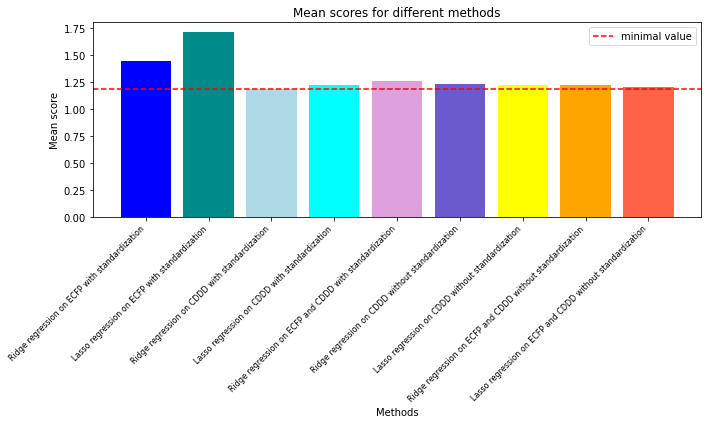

In [26]:
# Plotting the bar chart
plt.figure(figsize=(10, 6)) 
color_list = ['blue', 'darkcyan', 'lightblue', 'cyan', 'plum', 'slateblue', 'yellow', 'orange', 'tomato', 'darkred', 'gold', 'peru']

positions = range(score.shape[0])
plt.bar(positions, abs(score['mean score']), color=color_list)

# Adding method names instead of x-axis ticks
plt.xticks(positions, score['Method'], rotation=45, ha='right', fontsize=8)
plt.title('Mean scores for different methods')
plt.xlabel("Methods")
plt.ylabel("Mean score")

# Drawing a horizontal line at the height of the minimum value
min_value = min(abs(score['mean score']))
plt.axhline(y=abs(min_value), color='red', linestyle='--', label='minimal value')

plt.legend()

plt.tight_layout()
plt.show()
